In [1]:
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from itertools import product
import joblib
import pickle

In [2]:
path = '/Users/binit/PycharmProjects/ML_AIT_A3/pythonProject/ProjectA3/Data/Out_287.csv'

In [3]:
df = pd.read_csv(path)
df = df.drop(columns=['Unnamed: 0'])

In [4]:
df.head(5)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,1,22.69,1995.0,190.00,5.0
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,4.0
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,1,19.59,1995.0,187.74,5.0
3,BMW,2009,1100000,60000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0
4,BMW,2012,1100000,80000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0


In [5]:
df.describe()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats
count,6663.000000,6.663000e+03,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000,6663.000000
mean,2013.588924,5.243708e+05,73044.716644,1.499475,19.508243,1433.287858,87.871039,5.442593
std,3.898769,5.090416e+05,48214.360087,0.733034,3.913635,492.908839,31.622824,0.988814
min,1994.000000,2.999900e+04,1000.000000,1.000000,9.000000,624.000000,34.200000,4.000000
25%,2011.000000,2.500000e+05,38000.000000,1.000000,16.800000,1197.000000,68.000000,5.000000
50%,2014.000000,4.200000e+05,69123.000000,1.000000,19.500000,1248.000000,81.860000,5.000000
75%,2017.000000,6.500000e+05,100000.000000,2.000000,22.540000,1498.000000,100.000000,5.000000
max,2020.000000,1.000000e+07,500000.000000,4.000000,42.000000,3604.000000,400.000000,14.000000


In [6]:
columns_drop = ['seats','owner']
df.drop(columns=columns_drop, inplace=True)

In [7]:
# Binning is applied to categorize car prices:
selling_price = df['selling_price']  # Use your dataset
bins = [0, 250000, 500000, 750000, df['selling_price'].max()]  # Define bin edges
labels = [0, 1, 2, 3]  # Assign category labels

df['price_category_bins'] = pd.cut(df['selling_price'], bins=bins, labels=labels, include_lowest=True)
print(df['price_category_bins'].value_counts())

price_category_bins
1    2335
0    1719
2    1559
3    1050
Name: count, dtype: int64


In [56]:
dff = df.loc[:, df.columns.drop('selling_price')]

In [8]:
dff = df.copy()

In [9]:
dff.query("selling_price > 750000 and selling_price < 10000000").describe()

,year,selling_price,km_driven,mileage,engine,max_power
count,1049.000000,1.049000e+03,1049.000000,1049.000000,1049.000000,1049.000000
mean,2016.457579,1.287957e+06,56991.452812,18.200114,1877.421354,127.896273
std,2.223307,8.239498e+05,44162.316900,4.508758,529.265577,39.454969
min,2005.000000,7.510000e+05,1000.000000,9.000000,998.000000,62.100000
25%,2015.000000,8.500000e+05,25000.000000,15.100000,1493.000000,98.600000
50%,2017.000000,9.750000e+05,48000.000000,17.100000,1798.000000,120.000000
75%,2018.000000,1.350000e+06,77000.000000,22.000000,2179.000000,147.940000
max,2020.000000,7.200000e+06,426000.000000,28.400000,3604.000000,282.000000


In [10]:
dff[dff['price_category_bins']==3].describe()

,year,selling_price,km_driven,mileage,engine,max_power
count,1050.000000,1.050000e+03,1050.000000,1050.000000,1050.000000,1050.000000
mean,2016.458095,1.296254e+06,56965.746667,18.222781,1877.508571,128.155419
std,2.222310,8.663322e+05,44149.120843,4.566068,529.020795,40.320284
min,2005.000000,7.510000e+05,1000.000000,9.000000,998.000000,62.100000
25%,2015.000000,8.500000e+05,25000.000000,15.100000,1493.750000,98.600000
50%,2017.000000,9.750000e+05,48000.000000,17.100000,1877.000000,120.000000
75%,2018.000000,1.350000e+06,76784.750000,22.000000,2179.000000,147.985000
max,2020.000000,1.000000e+07,426000.000000,42.000000,3604.000000,400.000000


In [12]:
dff["km_driven"] = np.log1p(dff["km_driven"])  # 
dff["max_power"] = np.log1p(dff["max_power"])

In [11]:
# Compute the mean selling price for each brand and brands are encoded using their mean selling price to reduce categorical noise:
brand_mean_price = dff.groupby("brand")["selling_price"].mean().to_dict()

# Replace brand names with their average selling price
dff["brand_encoded"] = dff["brand"].map(brand_mean_price)

In [12]:
dff.head(3)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins,brand_encoded
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.00,3,2.826222e+06
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,19.59,1995.0,187.74,3,2.826222e+06


In [13]:
dff['seller_type'].value_counts()

seller_type
Individual          5977
Dealer               659
Trustmark Dealer      27
Name: count, dtype: int64

In [14]:
df.head(2)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.0,3
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.0,3


In [15]:
X_train, X_test, ytrain, ytest = train_test_split(
    dff.drop(columns=['price_category_bins','selling_price', 'brand', 'fuel','mileage']),
    dff['price_category_bins'],
    test_size=0.2,
    stratify=dff['price_category_bins'],  # Ensures equal class proportions
    random_state=42
)

columns_to_encode = ['seller_type','transmission']
scaler = MinMaxScaler()
oh = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('onehot', oh, columns_to_encode),  # One-hot encoding for categorical columns
    ('scaling', scaler, ['year', 'km_driven','engine','max_power',  'brand_encoded'])  # Scaling numerical columns
], remainder='passthrough')

X_train_trf = preprocessor.fit_transform(X_train)
X_test_trf = preprocessor.transform(X_test)


In [31]:
joblib.dump(brand_mean_price, 'brand_means.pkl')
print("brand_means.pkl has been saved.")

brand_means.pkl has been saved.


In [16]:
feature_names = ['seller_type_Individual', 'seller_type_Dealer','seller_type_Trustmark_Dealer','transmission_Automatic', 'transmission_Manual','year','km_driven','engine', 'max_power', 'brand_encoded']

In [17]:
X_train

,year,km_driven,seller_type,transmission,engine,max_power,brand_encoded
4506,2008,80000,Individual,Manual,1086.0,63.00,4.720181e+05
2325,2012,81632,Dealer,Manual,1399.0,68.00,5.081614e+05
2404,2015,130000,Individual,Automatic,2982.0,168.50,9.094595e+05
5353,2012,123000,Individual,Manual,1197.0,85.80,3.949493e+05
943,2015,62000,Dealer,Manual,1498.0,74.96,6.236416e+05
...,...,...,...,...,...,...,...
5746,2012,60000,Individual,Manual,1598.0,103.60,4.737470e+05
5090,2018,15000,Individual,Manual,1197.0,81.80,3.949493e+05
3947,2012,50000,Individual,Automatic,2143.0,170.00,2.242136e+06
1174,2016,70000,Individual,Manual,1248.0,88.50,3.949493e+05


In [18]:
X_train_trf[:5]

array([[0.        , 1.        , 0.        , 0.        , 1.        ,
        0.53846154, 0.15831663, 0.15503356, 0.07873155, 0.09977443],
       [1.        , 0.        , 0.        , 0.        , 1.        ,
        0.69230769, 0.16158717, 0.26006711, 0.09240022, 0.1089036 ],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.80769231, 0.25851703, 0.79127517, 0.36714051, 0.21026424],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.69230769, 0.24448898, 0.19228188, 0.14106069, 0.08030826],
       [1.        , 0.        , 0.        , 0.        , 1.        ,
        0.80769231, 0.12224449, 0.29328859, 0.11142701, 0.1380718 ]])

In [21]:
dff[dff['brand']=='BMW'].head(5)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,mileage,engine,max_power,price_category_bins,brand_encoded
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,22.69,1995.0,190.00,3,2.826222e+06
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,19.59,1995.0,187.74,3,2.826222e+06
3,BMW,2009,1100000,60000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06
4,BMW,2012,1100000,80000,Diesel,Individual,Automatic,16.07,1995.0,181.00,3,2.826222e+06


In [40]:
# Save the trained model
joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessor saved successfully!")

Preprocessor saved successfully!


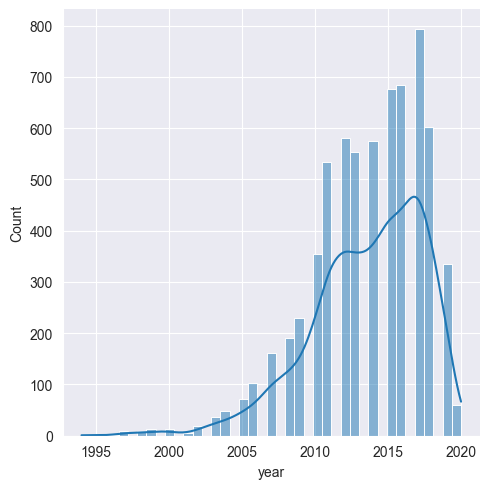

In [20]:
sns.displot(data=dff, x='year', kde=True)

<Axes: xlabel='selling_price'>

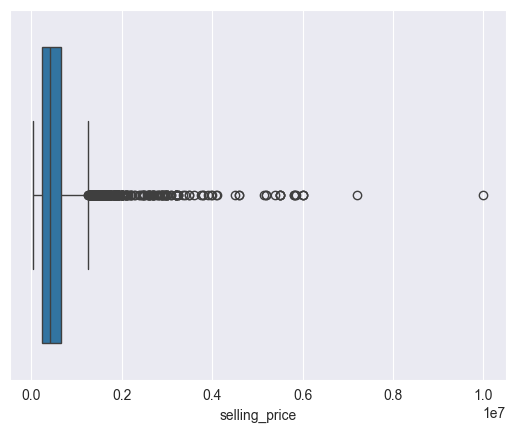

In [102]:
sns.boxplot(data=df, x='selling_price')

In [19]:
## Customs logistic regression 
class MyLogisticRegression:
    
    def __init__(self, cv:int=5, lr:float=0.1, 
                 max_iter:int=5000, weight_init:str='uniform', 
                 method:str='mini_batch', batch_size:int=64, l2:float=None,):
        self.lr = lr
        self.cv = cv
        self.max_iter = max_iter
        self.weight_init = weight_init
        self.method = method
        self.batch_size = batch_size
        self.l2 = 0 if l2 is None else l2
        
        valid_weight_init = ['uniform', 'normal', 'xavier','ones']
        
        if weight_init not in valid_weight_init:
            raise ValueError(f'weight_init must be one of {valid_weight_init}')
        
        valid_method = ['mini_batch', 'batch', 'stochastic']
        
        if method not in valid_method:
            raise ValueError(f'method must be one of {valid_method}')
        
    def fit(self, X, y):
        self.split = KFold(n_splits=self.cv)
        y_class = len(np.unique(y))

        if hasattr(X, "toarray"):
            X = X.toarray()  # Convert sparse matrix to dense

        # Ensure y is a NumPy array
        if not isinstance(y, np.ndarray):
            y = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)
        
        # One-Hot Encode y
        self.oh = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        y_encoded = self.oh.fit_transform(y.reshape(-1, 1))

        self.losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

        for fold, (train_index, test_index) in enumerate(self.split.split(X)):
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y_encoded[train_index], y_encoded[test_index]

            X_train = self._add_intercept(X_train)
            X_val = self._add_intercept(X_val)

            self.W = self.weight_initializer(X_train, y_class)
            self.velocity = np.zeros_like(self.W)

            fold_train_losses = []
            fold_train_accuracies = []

            if self.method == 'mini_batch':
                for i in range(self.max_iter):
                    ix = np.random.randint(0, X_train.shape[0])
                    X_train_batch = X_train[ix:ix + self.batch_size]
                    y_train_batch = y_train[ix:ix + self.batch_size]
                    loss = self.train(X_train_batch, y_train_batch)
                    fold_train_losses.append(loss)

                    _, train_pred = self.predict(X_train_batch)
                    train_accuracy = np.mean(np.argmax(y_train_batch, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)

                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")

            elif self.method == 'batch':
                for i in range(self.max_iter):
                    loss = self.train(X_train, y_train)
                    fold_train_losses.append(loss)

                    _, train_pred = self.predict(X_train)
                    train_accuracy = np.mean(np.argmax(y_train, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)

                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")

            elif self.method == 'stochastic':
                for i in range(self.max_iter):
                    idx = np.random.randint(X_train.shape[0])  # Select a random index
                    X_sto = X_train[idx, :].reshape(1, -1)  # Get the single sample
                    y_sto = y_train[idx].reshape(1, -1)  # Get the corresponding label
                    
                    loss = self.train(X_sto, y_sto)  # Train the model on this single example
                    
                    if not np.isnan(loss):  # Ensure the loss is valid
                        fold_train_losses.append(loss)
                    
                    _, train_pred = self.predict(X_sto)  # Get predicted class
                    train_accuracy = np.mean(np.argmax(y_sto, axis=1) == train_pred)
                    fold_train_accuracies.append(train_accuracy)
        
                    if i % 500 == 0:
                        print(f"Iteration {i} - Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}")
                    
            # Store the average training loss & accuracy for this fold
            avg_train_loss = np.mean(fold_train_losses)
            avg_train_accuracy = np.mean(fold_train_accuracies)
            self.losses.append(avg_train_loss)
            self.train_accuracies.append(avg_train_accuracy)

            val_pred = self.predict(X_val)[1]  # Get predicted class labels
            y_val_labels = self.oh.inverse_transform(y_val)

            # Compute validation loss
            val_loss = self.cross_entropy(self.softmax_(X_val @ self.W), y_val)
            self.valid_losses.append(val_loss)

            # Compute validation accuracy
            val_accuracy = np.mean(y_val_labels.flatten() == val_pred)
            self.valid_accuracies.append(val_accuracy)

            print(f"Fold: {fold}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
                
    def train(self, X, y):
        y_hat, _  = self.predict(X)

        error = y_hat - y
        m = max(X.shape[0], 1)  # Ensure division is valid

        loss = self.cross_entropy(y_hat, y) if m > 1 else float(np.mean(y_hat))
        
        grad = X.T @ error  +  2 * self.l2 * self.W 
        self.velocity = 0.8 * self.velocity - self.lr * grad
        self.W += self.velocity
        #self.W -= self.lr * grad
        
        return loss if not np.isnan(loss) else 0.0 
                
    def predict(self, X, is_test=False):
        if is_test:
            X = self._add_intercept(X)
    
        y_hat = X @ self.W
        y_hat = self.softmax_(y_hat)
        y_real = np.argmax(y_hat, axis=1)
        return y_hat, y_real
    
    def softmax_(self, X):
        X_max = np.max(X, axis=1, keepdims=True)  # Find max per row
        exp_shifted = np.exp(X - X_max)  # Shift values for numerical stability
        return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)  # Normalize
    
    def weight_initializer(self, X, num_classes):
        if self.weight_init == 'uniform':
            return np.random.uniform(low=-self.lr, high=self.lr, size=(X.shape[1], num_classes))
        elif self.weight_init == 'normal':
            return np.random.randn(X.shape[1], num_classes)
        elif self.weight_init == 'xavier':
            limit = np.sqrt(6 / (X.shape[1] + num_classes))
            return np.random.uniform(low=-limit, high=limit, size=(X.shape[1], num_classes))
        else:
            return np.ones((X.shape[1], num_classes))
        
    def cross_entropy(self, y, y_hat):
        if y_hat.size == 0 or y.size == 0:
            return 0.0  # Return zero loss to avoid NaN issues
    
        m = max(y.shape[0], 1)  # Prevent division by zero
        loss = - np.sum(y * np.log(y_hat + 1e-9))/m ## Prevent log(0)
        return  loss + self.l2*np.sum(self.W**2)
    
    def _add_intercept(self,X):
        return np.c_[np.ones(X.shape[0]), X]
    
    def classification_report(self, pred, y):
        # Ensure both pred and y are NumPy arrays
        pred = np.array(pred).flatten()
        y = np.array(y)
        
        if len(pred) == 0 or len(y) == 0:  # Prevent empty array issues
            return 0.0  # Return zero accuracy to avoid NaN
    
        # Extract unique labels from both predictions and ground truth
        labels = np.unique(np.concatenate((y, pred)))
        num_classes = len(labels)  # Update num_classes based on unique labels
    
        # Initialize confusion matrix
        cm = np.zeros((num_classes, num_classes), dtype=int)
        
        for true, pred_label in zip(y, pred):
            # Get index positions of true and predicted labels in `labels`
            true_idx = np.where(labels == true)[0]
            pred_idx = np.where(labels == pred_label)[0]
    
            if true_idx.size > 0 and pred_idx.size > 0:  # Check if valid indices exist
                cm[true_idx[0], pred_idx[0]] += 1
    
        # Compute metrics
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        fn = np.sum(cm, axis=1) - tp
    
        precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) > 0)
        recall = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) > 0)
        f1_score = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision, dtype=float), where=(precision + recall) > 0)
        
        accuracy_score = np.sum(np.diag(cm)) / np.sum(cm) if np.sum(cm) > 0 else 0.0
        
        # Weighted metrics
        class_counts = np.array([(y == label).sum() for label in labels]) / len(y)
        weighted_precision = np.sum(class_counts * precision)
        weighted_recall = np.sum(class_counts * recall)
        weighted_f1 = np.sum(class_counts * f1_score)
    
        # Print report
        print("\nClassification Report:\n")
        print("{:<10} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-score"))
        print("-" * 40)
        for i, label in enumerate(labels):
            print(f"{label:<10} {precision[i]:<10.2f} {recall[i]:<10.2f} {f1_score[i]:<10.2f}")
    
        return round(accuracy_score, 2), round(weighted_precision, 2), round(weighted_recall, 2), round(weighted_f1, 2)
    
    
    def _coeff_and_biases(self, feature_names):
        if not hasattr(self, "W"):
            raise ValueError("Model is not trained yet. Fit the model before retrieving coefficients.")
        
        coef = self.W[1:,:]  # Exclude bias term
        bias = self.W[0, :]
        print(coef.shape, len(feature_names))
        # Create a DataFrame for easy interpretation
        coef_df = pd.DataFrame(coef, index=feature_names, columns=[f"Class_{i}" for i in range(coef.shape[1])] if coef.ndim > 1 else ["Coefficient"])
        
        print("\nTop Important Features:")
        print(coef_df.abs().sum(axis=1).sort_values(ascending=False).head(10))

        return coef_df, bias

<Axes: >

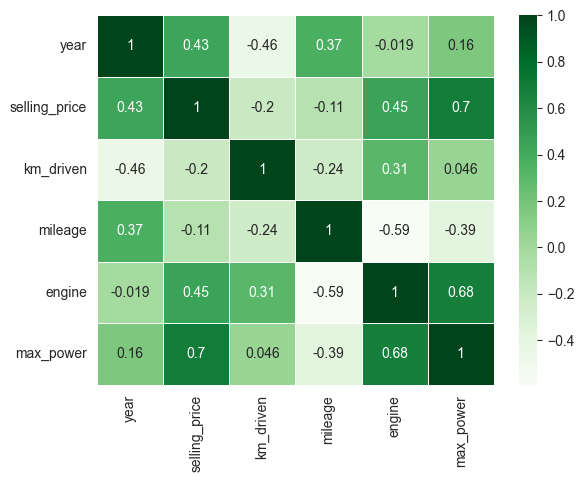

In [118]:
## remove engine, owners, seats
num_col = df.select_dtypes(include=['float','int64']).columns.tolist()
sns.heatmap(df[num_col].corr(), cmap='Greens', annot=True, linewidths=0.5)

In [81]:
df['selling_price'].describe()

count    6.663000e+03
mean     5.243708e+05
std      5.090416e+05
min      2.999900e+04
25%      2.500000e+05
50%      4.200000e+05
75%      6.500000e+05
max      1.000000e+07
Name: selling_price, dtype: float64

<Axes: xlabel='selling_price', ylabel='Count'>

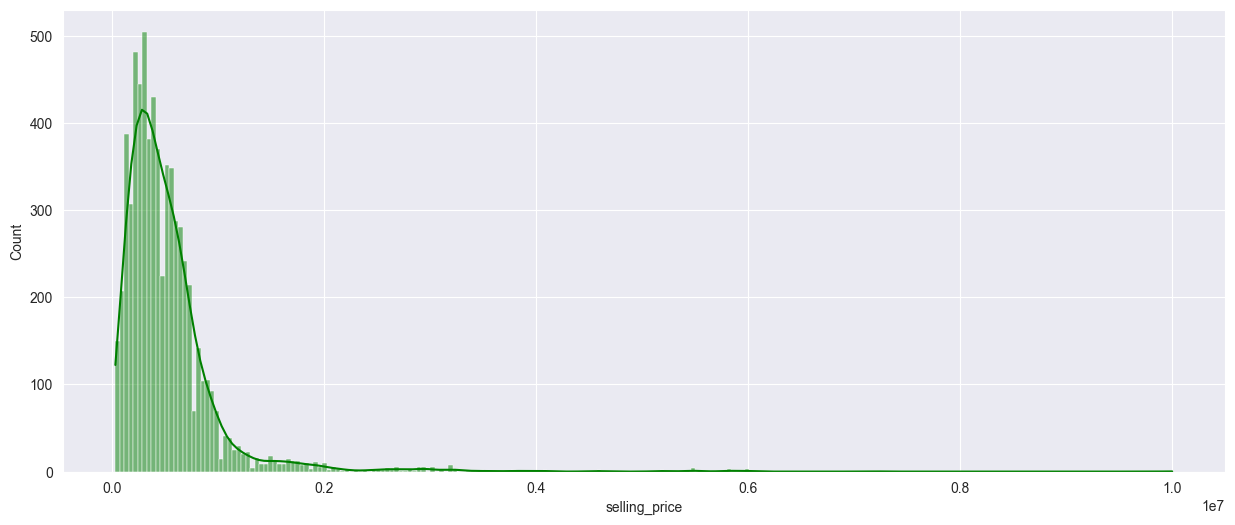

In [22]:
plt.figure(figsize=(15,6))
sns.histplot(data=df, x='selling_price', kde=True, color='green')

In [58]:
a = np.random.randint(low=1, high=100, size=(10,4))
print(a.shape, a.flatten().shape)

(10, 4) (40,)


In [36]:
model = MyLogisticRegression(weight_init='xavier', lr=0.0005, batch_size=64, max_iter=10000, method='batch', l2=0.01, cv=6)
model.fit(X_train_trf, ytrain)

Iteration 0 - Loss: 15.6131, Accuracy: 0.3499
Iteration 500 - Loss: 24.3434, Accuracy: 0.6949
Iteration 1000 - Loss: 32.4752, Accuracy: 0.7052
Iteration 1500 - Loss: 38.0710, Accuracy: 0.7084
Iteration 2000 - Loss: 42.0216, Accuracy: 0.7079
Iteration 2500 - Loss: 44.8339, Accuracy: 0.7068
Iteration 3000 - Loss: 46.8474, Accuracy: 0.7068
Iteration 3500 - Loss: 48.2986, Accuracy: 0.7059
Iteration 4000 - Loss: 49.3515, Accuracy: 0.7057
Iteration 4500 - Loss: 50.1202, Accuracy: 0.7059
Iteration 5000 - Loss: 50.6847, Accuracy: 0.7059
Iteration 5500 - Loss: 51.1012, Accuracy: 0.7059
Iteration 6000 - Loss: 51.4099, Accuracy: 0.7059
Iteration 6500 - Loss: 51.6398, Accuracy: 0.7061
Iteration 7000 - Loss: 51.8115, Accuracy: 0.7059
Iteration 7500 - Loss: 51.9401, Accuracy: 0.7055
Iteration 8000 - Loss: 52.0368, Accuracy: 0.7055
Iteration 8500 - Loss: 52.1097, Accuracy: 0.7055
Iteration 9000 - Loss: 52.1647, Accuracy: 0.7055
Iteration 9500 - Loss: 52.2063, Accuracy: 0.7055
Fold: 0, Train Loss: 46.

In [39]:
_ , pred = model.predict(X_test_trf, is_test=True)
print(model.classification_report(pred, ytest))
print(len(pred))


Classification Report:

Class      Precision  Recall     F1-score  
----------------------------------------
0          0.83       0.80       0.81      
1          0.63       0.71       0.67      
2          0.54       0.56       0.55      
3          0.83       0.63       0.72      
(np.float64(0.68), np.float64(0.69), np.float64(0.68), np.float64(0.69))
1333


In [43]:
w, _ = model._coeff_and_biases(feature_names) ##feature importance 
print(w)

(10, 4) 10

Top Important Features:
year                            70.910353
max_power                       62.449079
brand_encoded                   41.988042
transmission_Manual             20.288856
transmission_Automatic          19.582516
engine                          16.461540
seller_type_Dealer              14.395618
seller_type_Trustmark_Dealer    13.834105
seller_type_Individual          12.393648
km_driven                        2.546607
dtype: float64
                                Class_0   Class_1   Class_2    Class_3
seller_type_Individual         4.161615  1.549013 -1.642247  -5.040773
seller_type_Dealer             5.116462  1.720745 -1.769878  -5.788532
seller_type_Trustmark_Dealer   5.214722  1.597802 -1.324596  -5.696985
transmission_Automatic         7.021064  2.979144 -1.968778  -7.613530
transmission_Manual            7.247587  2.980364 -2.217318  -7.843586
year                         -27.107099 -8.599632  9.165188  26.038435
km_driven                     -0

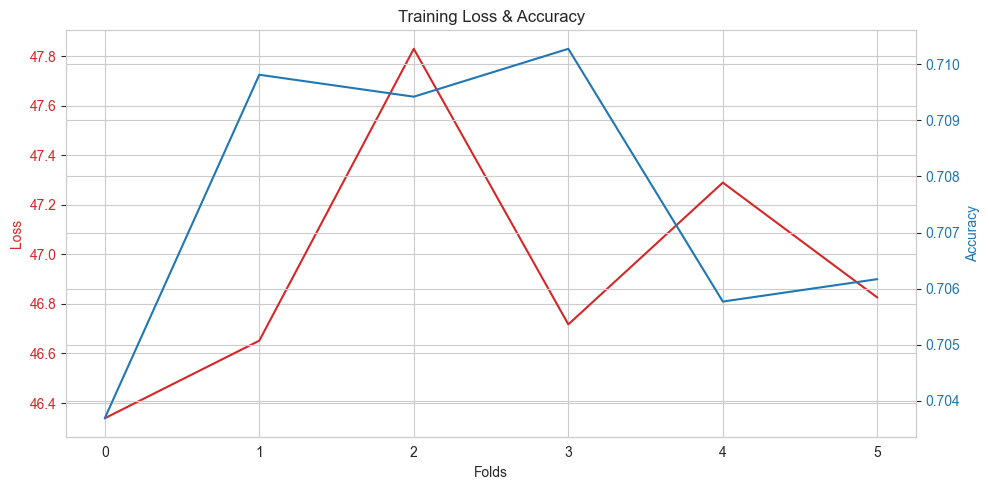

In [37]:
def plot_loss_accuracy(losses, accuracies, title="Training Progress"):
    """
    Plots training loss and accuracy over iterations.
    Returns:
    - None (Displays the plot)
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Folds")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(losses, color="tab:red", label="Loss")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()  # Create a secondary y-axis
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(accuracies, color="tab:blue", label="Accuracy")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    plt.title(title)
    fig.tight_layout()  # Adjust layout to prevent overlap

    plt.show()


plot_loss_accuracy(model.losses, model.train_accuracies, title="Training Loss & Accuracy")

In [43]:
joblib.dump(model, "model.pkl")
print("Preprocessor saved successfully!")

Preprocessor saved successfully!


In [138]:
mlflow.set_experiment("MLflow_Classification_Registry")

# Lists of hyperparameters
methods = ["batch", "mini_batch", "stochastic"]  
weights = ["xavier", "normal", "uniform"]
penalty = [None, 0.01]
lr = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]  # Added batch sizes

# Initialize best model tracking
best_model_acc, best_acc, best_params_acc = None, float('-inf'), None
best_run_id = None

def run_experiment(method, weight, lr, penalty, batch_size):
    """Runs ML experiments, logs results in MLflow, and tracks the best models."""
    global best_model_acc, best_acc, best_params_acc, best_run_id

    params = {
        "method": method, "lr": lr, "weight_init": weight, "l2": penalty, "batch_size": batch_size
    }

    print(f"Running MyLogisticRegression | {method} | {weight} | LR: {lr} | l2: {penalty} | Batch Size: {batch_size}")

    # Initialize model with current hyperparameters
    model = MyLogisticRegression(
        lr=lr, 
        max_iter=7000, 
        weight_init=weight, 
        method=method,
        batch_size=batch_size, 
        l2=penalty
    )

    with mlflow.start_run(run_name=f"method-{method}-lr-{lr}-weight-{weight}-batch-{batch_size}", nested=True):

        # Train the model
        model.fit(X_train_trf, ytrain)

        # Predictions
        _, y_pred = model.predict(X_test_trf, is_test=True)

        # Compute metrics
        acc, precision, recall, f1_score = model.classification_report(y_pred, ytest)

        # Log hyperparameters & metrics in MLflow
        mlflow.log_params(params)
        mlflow.log_metrics({"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1_score})

        # Save Model Signature
        signature = mlflow.models.infer_signature(X_train_trf, model.predict(X_train_trf, is_test=True)[1])
        mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)

        print(f" Model: MyLogisticRegression | Method: {method} | Accuracy: {acc:.4f} | F1-Score: {f1_score:.4f}")

        # Track the Best Model Based on Accuracy (HIGHER IS BETTER)
        if acc > best_acc:
            best_acc = acc
            best_model_acc = model
            best_params_acc = params
            best_run_id = mlflow.active_run().info.run_id  # Save the best run ID for registry


# Iterate over all hyperparameter combinations
combinations_ = product(methods, weights, lr, batch_sizes)

# Run all experiments
for method, weight, lr, batch_size in combinations_:
    run_experiment(method, weight, lr, None, batch_size)

# Final Results: Best Model Based on Accuracy
print(f"Best Model by Accuracy: {best_model_acc} with Accuracy: {best_acc:.4f}")

mlflow.end_run()

# -----------------------
# Register Best Model in MLflow Model Registry
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Make sure MLflow server is running

if best_run_id:
    model_uri = f"runs:/{best_run_id}/model"
    model_name = "st124783-a3-model"  # Replace with your student ID

    # Register the best model
    model_version = mlflow.register_model(model_uri, model_name)
    print(f"\n Registered Model: {model_name} (Version: {model_version})")

    # Move the Model to 'Staging'
    client = MlflowClient()
    latest_version = client.get_latest_versions(model_name, stages=["None"])[0].version

    client.transition_model_version_stage(name=model_name, version=latest_version, stage="Staging")
    print(f"Model Version {latest_version} is now in 'Staging'!")

2025/03/17 23:08:03 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_Classification_Registry' does not exist. Creating a new experiment.


Running MyLogisticRegression | batch | xavier | LR: 0.01 | l2: None | Batch Size: 32
Iteration 0 - Loss: 15.4983, Accuracy: 0.4641
Iteration 500 - Loss: 8.3558, Accuracy: 0.6794
Iteration 1000 - Loss: 6.3595, Accuracy: 0.6789
Iteration 1500 - Loss: 7.3733, Accuracy: 0.6100
Iteration 2000 - Loss: 8.0450, Accuracy: 0.5424
Iteration 2500 - Loss: 10.0565, Accuracy: 0.5227
Iteration 3000 - Loss: 8.5419, Accuracy: 0.6677
Iteration 3500 - Loss: 6.9325, Accuracy: 0.6041
Iteration 4000 - Loss: 9.0302, Accuracy: 0.5910
Iteration 4500 - Loss: 7.6723, Accuracy: 0.6393
Iteration 5000 - Loss: 8.2311, Accuracy: 0.6606
Iteration 5500 - Loss: 7.4938, Accuracy: 0.6651
Iteration 6000 - Loss: 9.5955, Accuracy: 0.6489
Iteration 6500 - Loss: 7.0547, Accuracy: 0.6360
Fold: 0, Train Loss: 8.1863, Train Accuracy: 0.6055, Val Loss: 7.1282, Val Accuracy: 0.6595
Iteration 0 - Loss: 16.5833, Accuracy: 0.4308
Iteration 500 - Loss: 7.4965, Accuracy: 0.6520
Iteration 1000 - Loss: 9.0381, Accuracy: 0.5471
Iteration 15

Successfully registered model 'st124783-a3-model'.
2025/03/17 23:19:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st124783-a3-model, version 1


 Model: MyLogisticRegression | Method: stochastic | Accuracy: 0.5700 | F1-Score: 0.5400
🏃 View run method-stochastic-lr-0.0001-weight-uniform-batch-128 at: http://127.0.0.1:5000/#/experiments/1/runs/9143f88ef54f4ddcae05b4dc3833cf9f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
Best Model by Accuracy: <__main__.MyLogisticRegression object at 0x16595b470> with Accuracy: 0.7000

 Registered Model: st124783-a3-model (Version: <ModelVersion: aliases=[], creation_timestamp=1742228386680, current_stage='None', description='', last_updated_timestamp=1742228386680, name='st124783-a3-model', run_id='1d7dc3517be246b1ba404c4fa7ae335e', run_link='', source='/Users/binit/PycharmProjects/ML_AIT_A3/mlruns/1/1d7dc3517be246b1ba404c4fa7ae335e/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='1'>)
Model Version 1 is now in 'Staging'!


Created version '1' of model 'st124783-a3-model'.
/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_15615/3042286121.py:89: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version = client.get_latest_versions(model_name, stages=["None"])[0].version
/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_15615/3042286121.py:91: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_mod

In [139]:
## Best Model 
print(best_acc, best_model_acc, best_params_acc)

0.7 <__main__.MyLogisticRegression object at 0x16595b470> {'method': 'batch', 'lr': 0.001, 'weight_init': 'xavier', 'l2': None, 'batch_size': 64}


In [43]:
import cloudpickle

# Suppose 'preprocessor' is your pipeline or other object
with open("preprocess_test.pkl", "wb") as f:
    cloudpickle.dump(preprocessor, f)

print("Successfully saved preprocessor to preprocess_test.pkl with cloudpickle.")

Successfully saved preprocessor to preprocess_test.pkl with cloudpickle.


In [44]:
with open("model_test.pkl", "wb") as f:
    cloudpickle.dump(model, f)

print("Successfully saved model to model_test.pkl with cloudpickle.")

Successfully saved model to model_test.pkl with cloudpickle.


In [45]:
print(cloudpickle.__version__)

3.1.1


This notebook implements a custom logistic regression model for car price classification. It covers:
	- Data preprocessing (feature engineering, scaling, encoding)
	- Model training using various gradient descent methods
	- Performance evaluation with metrics
	- Hyperparameter tuning and model tracking with MLflow
	- Model serialization for deployment

This structured pipeline ensures an end-to-end workflow for building and optimizing a machine learning classification model. The custom MyLogisticRegression class implements a multinomial logistic regression model with gradient-based optimization techniques. It supports three training methods: mini-batch, batch, and stochastic gradient descent, allowing flexible learning strategies. The model includes custom weight initialization (uniform, normal, Xavier) and L2 regularization to prevent overfitting. It uses one-hot encoding for categorical target variables and applies softmax activation for multi-class classification. The training process incorporates cross-validation (KFold), tracks losses and accuracies per fold, and logs performance metrics for evaluation. Finally, MLflow is used for hyperparameter tuning and model tracking, ensuring systematic experimentation and model selection.

Ml Flow
Experiment Tracking → I Logged hyperparameters and metrics to compare models that helped me to see my best model
Easy Deployment → Models in Staging can be transitioned to Production automatically.But here i did till staging only. I found out mlflow Tracks model sources, making debugging easier too this helps to improve model performance overtime too. 